<a href="https://colab.research.google.com/github/kaleem500bc/CartPole-DQNAgent-pytorch/blob/main/DQN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyVirtualDisplay

In [2]:
import torch
from torch import nn
import gym
import os
from matplotlib import pyplot as plt
import numpy as np
from collections import deque
import random
import time
from IPython import display
from pyvirtualdisplay import Display
# from IPython import display
from IPython.display import clear_output
import copy
plt.ion()

In [3]:
# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [18]:
class Agent:
  def __init__(self,state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    self.gamma = 0.99
    self.epsilon = 1.0
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.01
    self.learning_rate = 0.00025
    self.model = self.create_model()
    self.targetModel = copy.deepcopy(self.model)
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.learning_rate)
    self.criterion = nn.MSELoss()

  # Model that will learn the Q-function/ Agent that will play the game
  def create_model(self):
    model = nn.Sequential(
        nn.Linear(self.state_size,64),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(64, 128),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(128, 256),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(256, 512),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(512, 256),
        nn.LeakyReLU(negative_slope=0.5),
        nn.Linear(256,self.action_size)
    )
    model.to("cuda")
    return model
    
  # Replay memory where different episode will be store
  def replay_buffer(self, state,action, reward, next_state, done):
    state = torch.tensor(state,dtype=torch.float).to("cuda")
    action = torch.tensor(action,dtype=torch.float).to("cuda")
    reward = torch.tensor(reward,dtype=torch.float).to("cuda")
    next_state = torch.tensor(next_state,dtype=torch.float).to("cuda")
    
    self.memory.append((state,action, reward, next_state,done))
  
  # Get action that the agent should take
  def action(self, state,episode):

    # Allow random exploration for first 100 episodes
    if np.random.rand() <= self.epsilon and episode < 200:
      
      return random.randrange(self.action_size)

    # Get action from the agent/ exploitation
    state = state.to("cuda")
    act_values = self.model(state)
    return int(torch.argmax(act_values).item())


  # Train the model according to q-learning
  def training(self,batch_size, training_iter):
    # print("Training Iteration: ", training_iter)
    minibatch = random.sample(self.memory, batch_size)
    targetUpdate = 0
    for state,action, reward, next_state,done in minibatch:
      targetUpdate += 1
      actual_reward = reward
      state = state.to("cuda")
      next_state = next_state.to("cuda")

      predicted_reward = self.model(state)
      predicted_reward = predicted_reward[int(action.item())] 
      if not done:
        actual_reward = reward + self.gamma * torch.amax(
            self.targetModel(next_state)
            )
        
        self.optimizer.zero_grad()
    
        loss = self.criterion(predicted_reward,actual_reward)
        loss.backward()
        self.optimizer.step()
      else:
        self.optimizer.zero_grad()
        loss = self.criterion(predicted_reward,actual_reward)
        loss.backward()
        self.optimizer.step()
      if targetUpdate >= 50:
        targetUpdate = 0
        self.targetModel = copy.deepcopy(self.model)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  





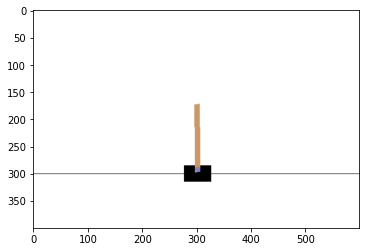

In [19]:
env = gym.make("CartPole-v0").env
obs = env.reset()
plt.imshow(env.render("rgb_array"))

In [20]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)
agent

In [21]:


def populate_replayBuffer(agent,env, n_episode):
  d = Display()
  d.start()
  done = False
  replayBuffer = 2000
  training_iter = 1
  batch_size = 128
  score = []
  
  for e in range(n_episode):
    state = env.reset()
    # img = plt.imshow(env.render('rgb_array'))

    state = torch.tensor(state,dtype=torch.float)
    buffer_size = 2000
   
    for i in range(2000):

      action = agent.action(state,e)
      next_state, reward, done, _ = env.step(action)
      reward = reward if not done else -10
      agent.replay_buffer(state,action,reward,next_state,done)
      state = torch.tensor(next_state,dtype=torch.float)
      
      # img.set_data(env.render('rgb_array'))
      # plt.axis('off')
      # clear_output(wait=True)
      # display.display(plt.gcf())

      if done:
        if len(agent.memory) >= replayBuffer:
          score.append(i)
          print("episods: {}, Max score: {}, Current Score: {}".format(e,max(score), i))
        break

    if len(agent.memory) >= replayBuffer:
      training_iter += 1
      agent.training(batch_size, training_iter)
  return score

In [ ]:
score = populate_replayBuffer(agent,env,300)

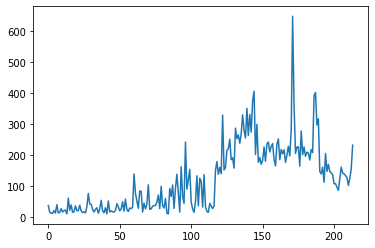

In [23]:
plt.plot(score)

KeyboardInterrupt: ignored

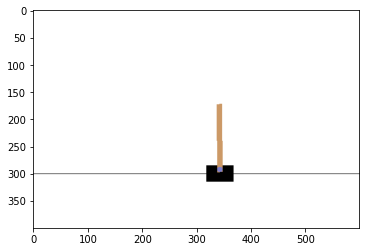

In [24]:
state = env.reset()
done = False
display_img = plt.imshow(env.render("rgb_array"))
i = 0
while not done:
  state = torch.tensor(state,dtype=torch.float).to("cuda")
  action = agent.model(state)
  action = int(torch.argmax(action).item())
  state, reward, done, _ = env.step(action)
  display_img.set_data(env.render("rgb_array"))
  clear_output(wait=True)
  display.display(plt.gcf())
  i += 1
print(i)